# Установка необходимых библиотек

В оригинальном репозитории были слишком старые версии библиотек, которые не собирались вместе. Прежде всего изменила `requirements.txt` и поправила версию `mujoco`

In [ ]:
import os

!wget  https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz
!mkdir ~/.mujoco
!tar -xf mujoco210-linux-x86_64.tar.gz -C /root/.mujoco/
os.environ['LD_LIBRARY_PATH'] += ":/root/.mujoco/mujoco210/bin"

In [ ]:
!pip install -r ./alm/requirements.txt
!sudo apt-get install libglew-dev libosmesa6-dev patchelf

In [ ]:
!wandb login

# Запуск экспериментов

Я все логгировала в wandb, поэтому буду прекреплять результаты как ссылку на wandb.

Запустим сначала просто ALM в разных средах

## [HalfCheetah-v2](https://wandb.ai/polinasha-team/alm_HalfCheetah-v2/runs/7h0q41vj?nw=nwuserpolinasha960)

In [ ]:
!python3 ./alm/train.py id=HalfCheetah-v2 wandb_log=True save_snapshot=True num_train_steps=300000 wandb_run_name='ALM_3' seed=239

В целом результаты похожи, только у меня модель не смогла за 300к шагов дойти до 12к реварда (дошел до 11400). Можно было бы подумать, что это ревард на тесте, но он еще нижe. Я запускала на каггле на P100. И у меня получилось время работы примерно в 2 раза лучше, чем у авторов.

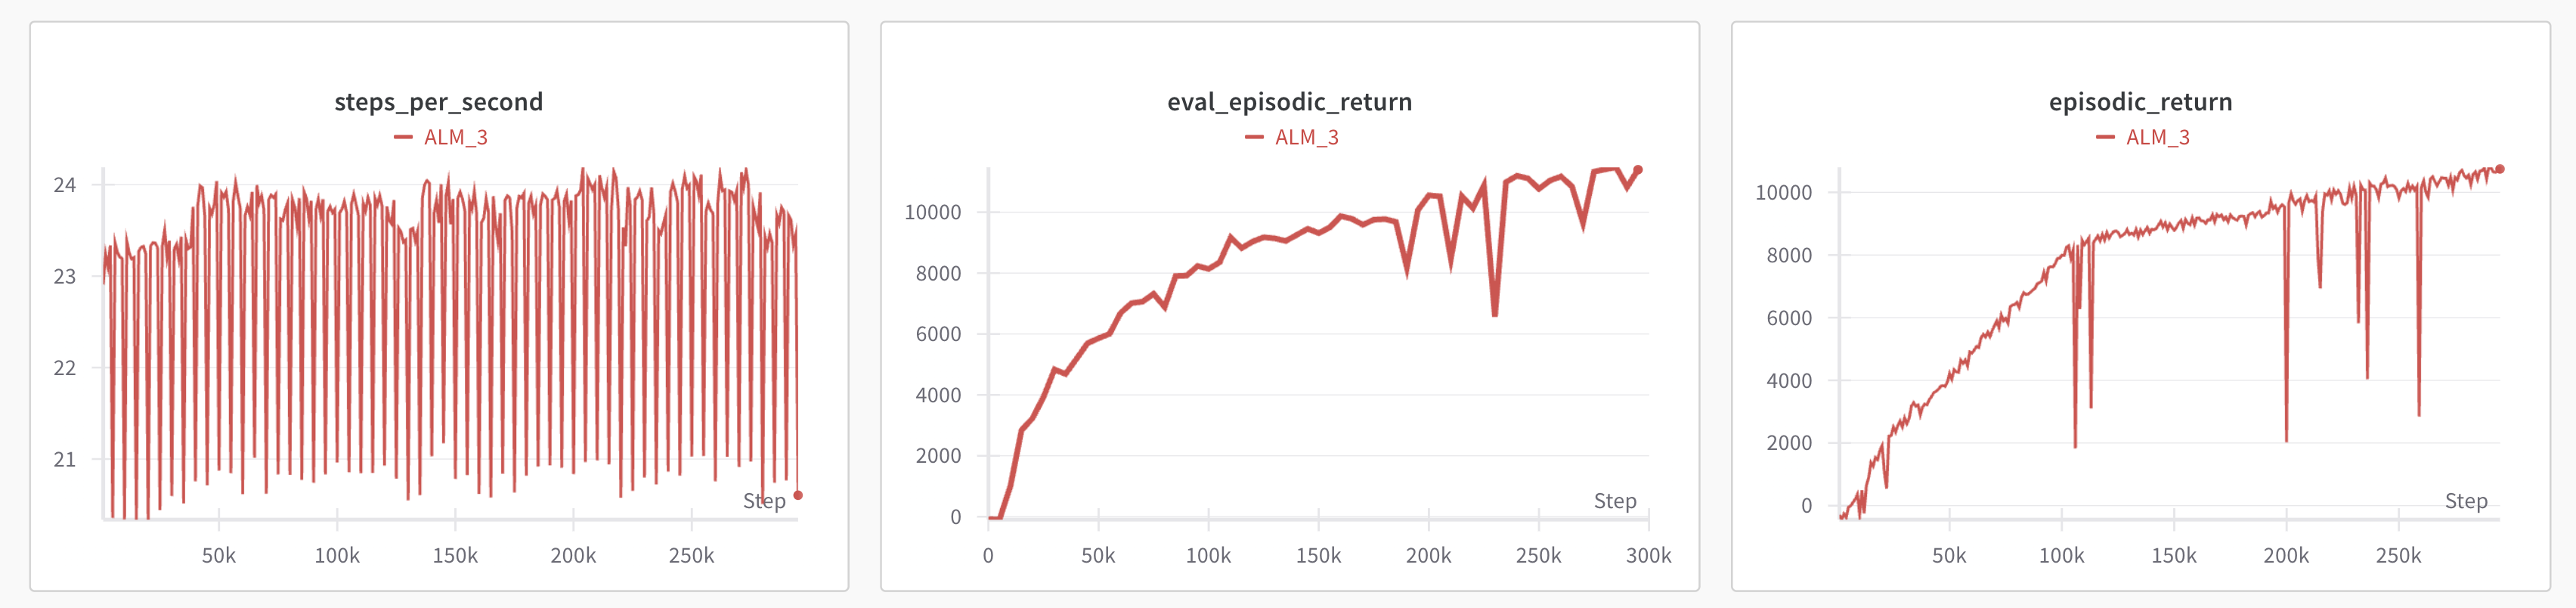

## [Ant-v2](https://wandb.ai/polinasha-team/alm_Ant-v2/runs/1vytsa6i?nw=nwuserpolinasha960)

In [ ]:
!python3 ./alm/train.py id=Ant-v2 wandb_log=True save_snapshot=True num_train_steps=300000 wandb_run_name='ALM_3' seed=239

Здесь у меня получилось выбить даже больше реварда чем у авторов, причем за меньшее число шагов.  Из отличий, если в прошлом запуске `episodic_length` был стабтлен, то здесь он зааметно изменялся в начале, но и в конце были выбросы

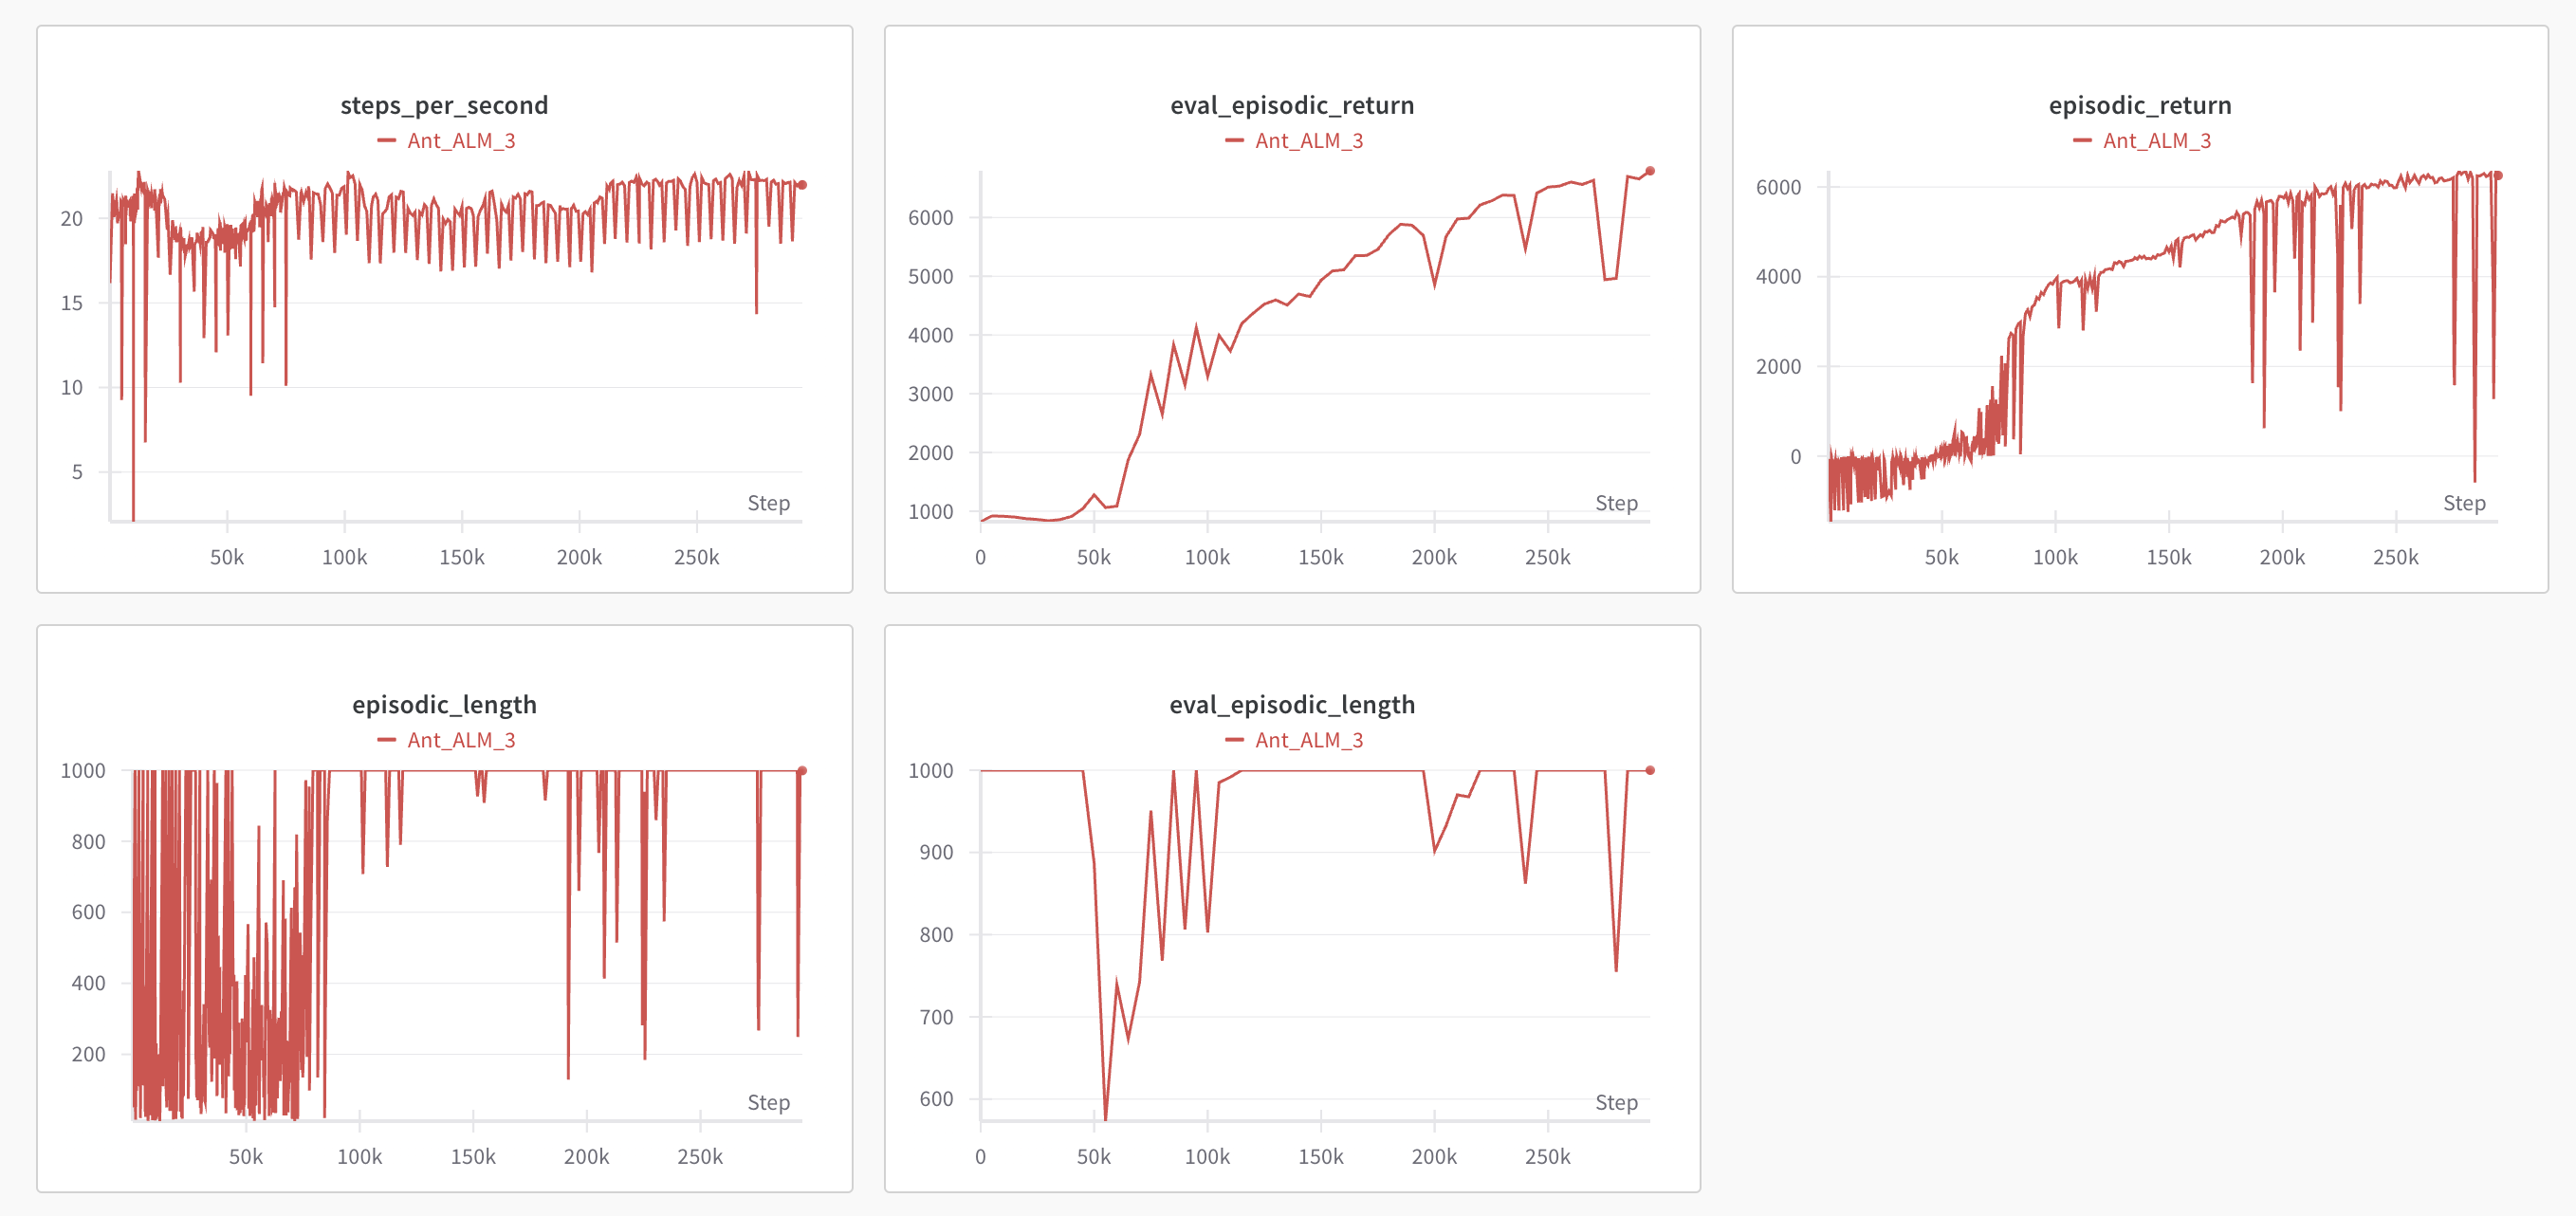


## [Humanoid-v2](https://wandb.ai/polinasha-team/alm_Humanoid-v2/runs/gds50wum?nw=nwuserpolinasha960)

In [ ]:
!python3 ./alm/train.py id=Humanoid-v2 wandb_log=True save_snapshot=True num_train_steps=300000 wandb_run_name='ALM_3' seed=239

Здесь тоже получилось выбить больше реварда чем у авторов. Длина эпизода изменяется меньше, чем в муравье, однако по графикам видно, что обучение очень нестабильно

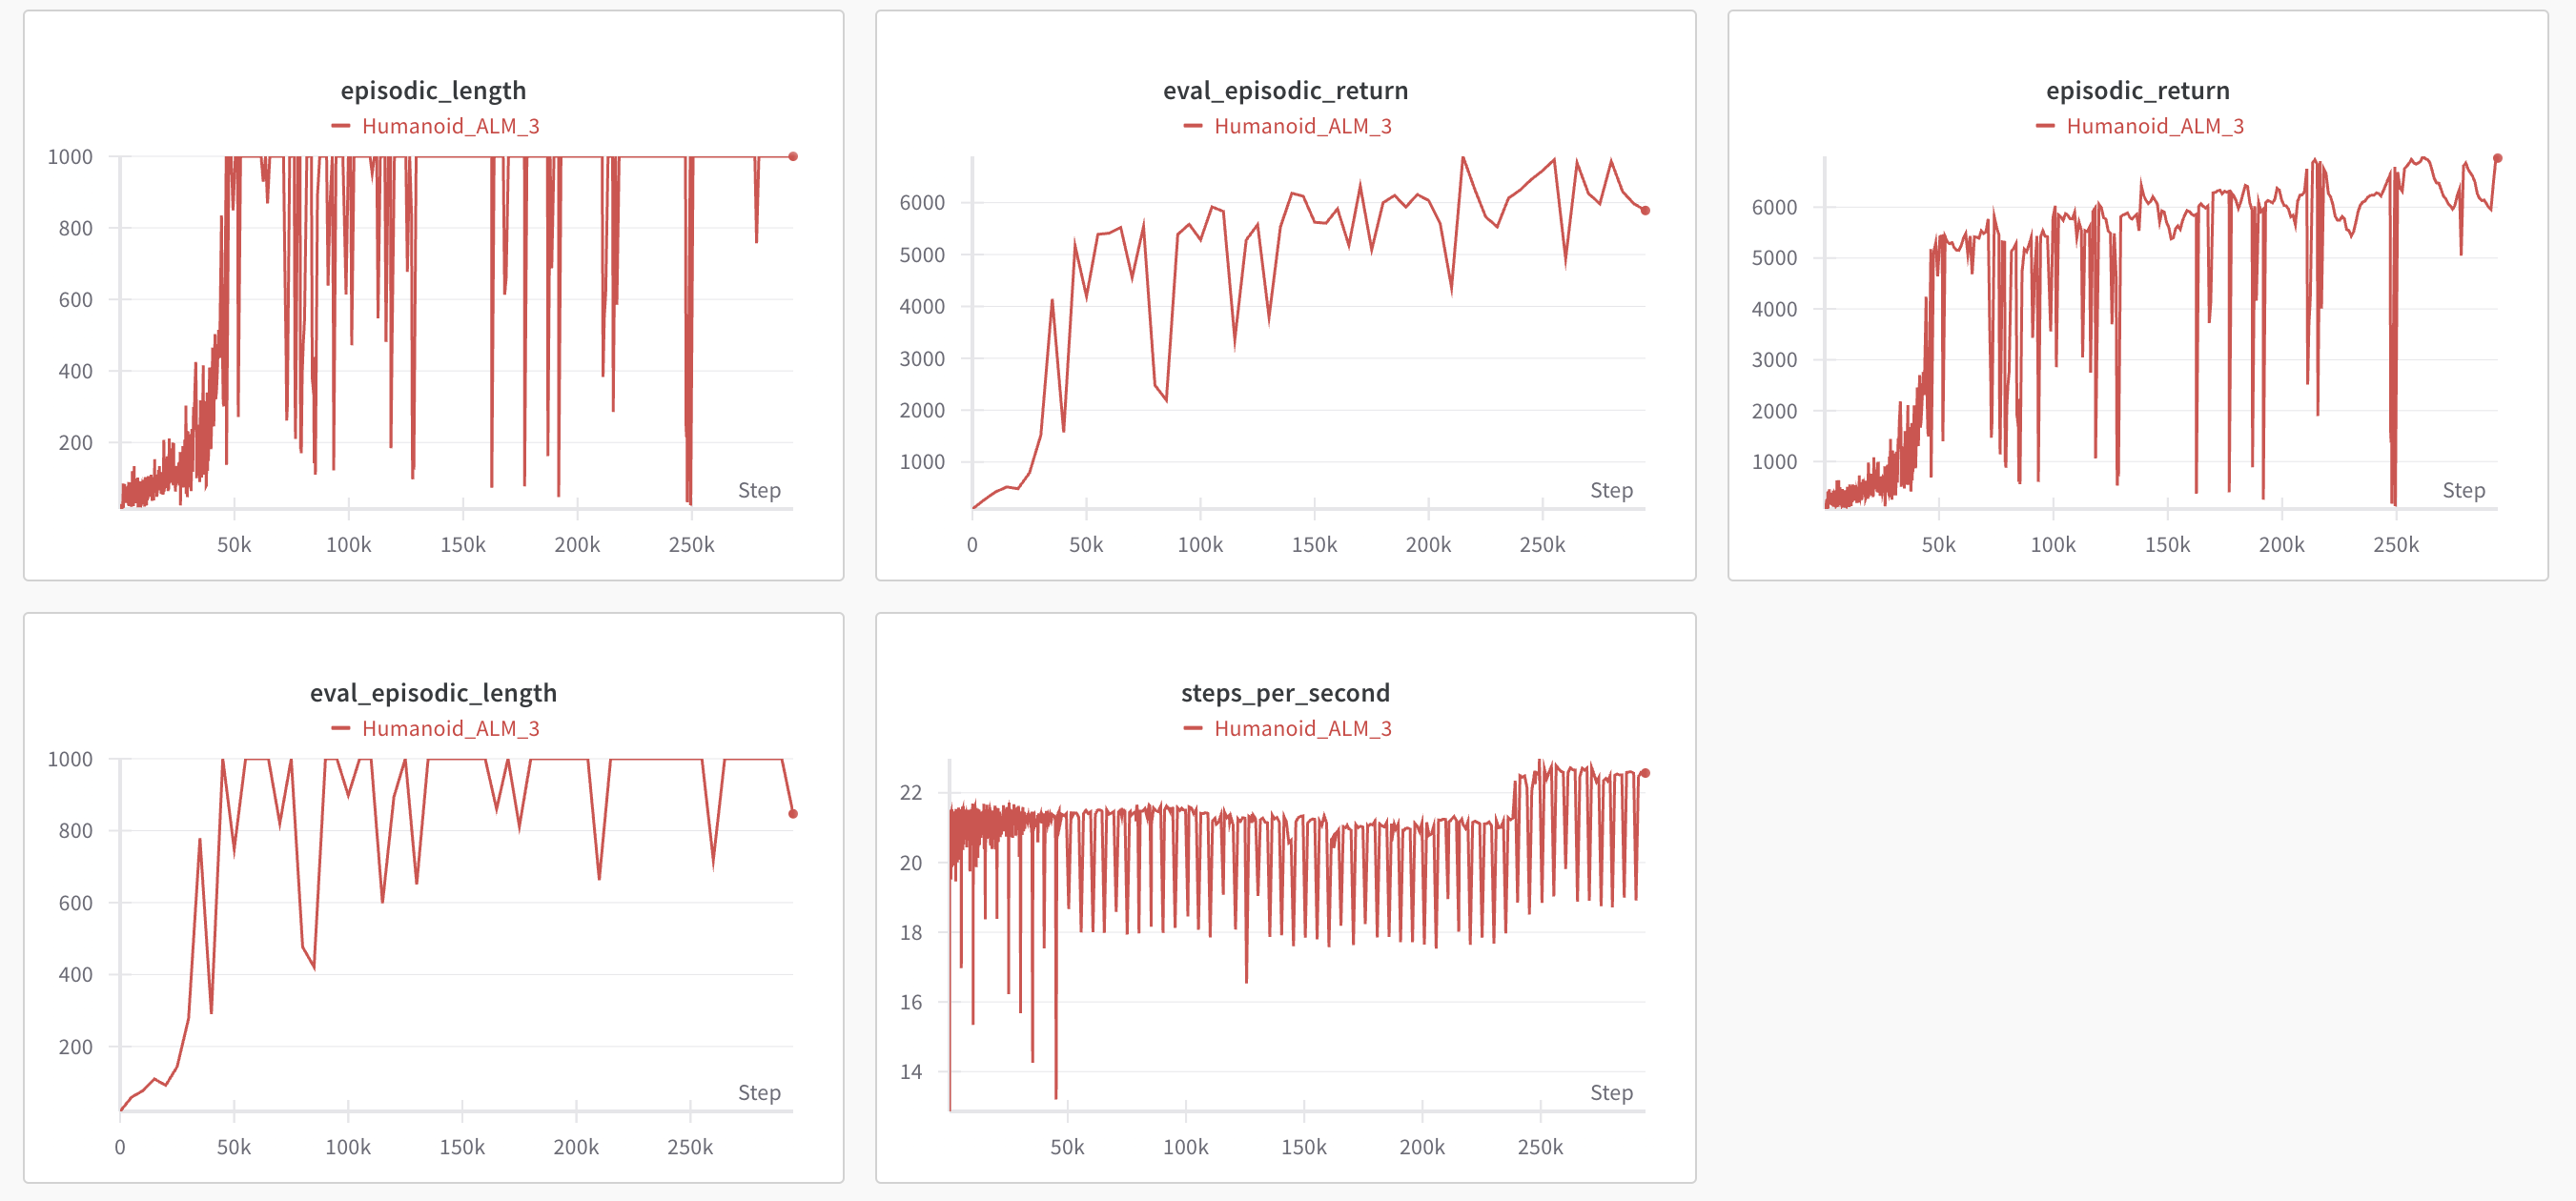

Затем я решила проводить эксперименты только с HalfCheetah-v2.

Начнем с эксперимента по варьированию `sequence_length` (параметр, который отвечает за длину семплов из replay буффера, через которые оценивается лосс для encoder'a и latent-space model). Увеличение этого параметра может привести к улучшению качества работы.

Итак, было 3 запуска для $K = 1, 3, 5$:

[ALM(1)](https://wandb.ai/polinasha-team/alm_HalfCheetah-v2/runs/p5jvf6jp)
[ALM(3)](https://wandb.ai/polinasha-team/alm_HalfCheetah-v2/runs/7h0q41vj?nw=nwuserpolinasha960)
[ALM(5)](https://wandb.ai/polinasha-team/alm_HalfCheetah-v2/runs/343xpkzt?nw=nwuserpolinasha960)
[SAC](https://wandb.ai/polinasha-team/alm_HalfCheetah-v2/runs/h2kj6kcb?nw=nwuserpolinasha960)

In [ ]:
!python3 ./alm/train.py id=HalfCheetah-v2 wandb_log=True save_snapshot=True num_train_steps=300000 seq_len=1 wandb_run_name='ALM_1' seed=239
!python3 ./alm/train.py id=HalfCheetah-v2 wandb_log=True save_snapshot=True num_train_steps=300000 seq_len=3 wandb_run_name='ALM_3' seed=239
!python3 ./alm/train.py id=HalfCheetah-v2 wandb_log=True save_snapshot=True num_train_steps=300000 seq_len=5 wandb_run_name='ALM_5' seed=239

В статье ALM(3) выдает примерно на 2000 реварда больше, чем ALM(1) и ALM(5), которые работают примерно одинаково. Все три метода сильно лучше SAC (который выбивает всего 6000 у авторов статьи). У меня наблюдается нечто иное: ALM(3) и ALM(1) работают примерно одинаково (разве что ALM(1) достигает такого уровня лишь в самый последний момент), а вот ALM(5) работает примерно также как SAC,который в данном случае выбивает около 10к реварда. Также в статье не были приведены графики для времени работы в зависимости от $K$, но я это залоггироваола и на графиках видно, что чем больше K, тем дольше работает алгоритм (что в целом логично).

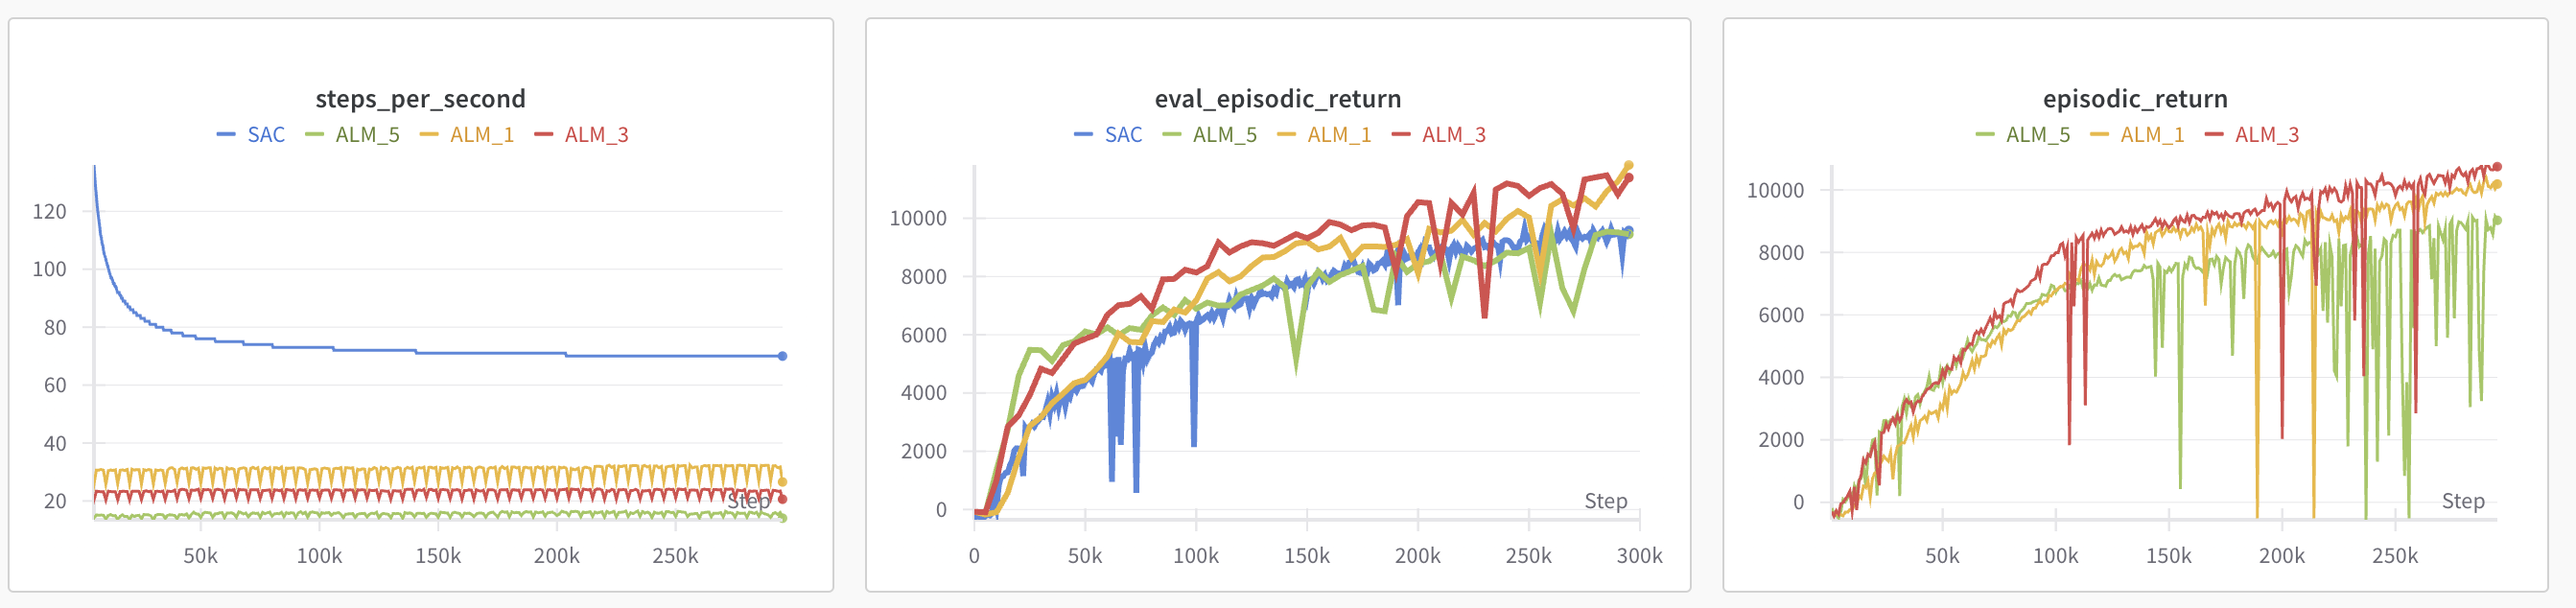

Для двух следующих экспериментов у авторов не было кода. Поэтому я сама добавила соответствующие настройки в конфиг и изменила часть кода:

Первый эксперимент был с удалением различных частей лосса. Он должен показать, насколько важна та или иная часть:

[Без classifier loss](https://wandb.ai/polinasha-team/alm_HalfCheetah-v2/runs/k7ubriqj?nw=nwuserpolinasha960)

[Без KL loss](https://wandb.ai/polinasha-team/alm_HalfCheetah-v2/runs/yvvxqbyr?nw=nwuserpolinasha960)

[Без value loss](https://wandb.ai/polinasha-team/alm_HalfCheetah-v2/runs/f5nq5as4?nw=nwuserpolinasha960)


In [ ]:
!python3 ./alm/train.py id=HalfCheetah-v2 wandb_log=True save_snapshot=True num_train_steps=300000 seq_len=3 wandb_run_name='ALM_3_without_classifier' seed=239 use_classifier_loss=False
!python3 ./alm/train.py id=HalfCheetah-v2 wandb_log=True save_snapshot=True num_train_steps=300000 seq_len=3 wandb_run_name='ALM_3_without_KL' seed=239 use_kl_loss=False
!python3 ./alm/train.py id=HalfCheetah-v2 wandb_log=True save_snapshot=True num_train_steps=300000 seq_len=3 wandb_run_name='ALM_3_without_value' seed=239 use_value_loss=False

В сущности, мои результаты совпали с результатами статьи. Без KL части ничего не обучается. Но на протяжении всего обучения часть без Value была лучше, чем просто алгоритм. Возможно, я подобрала удачный сид, но в статье не было больших различий между запусками.

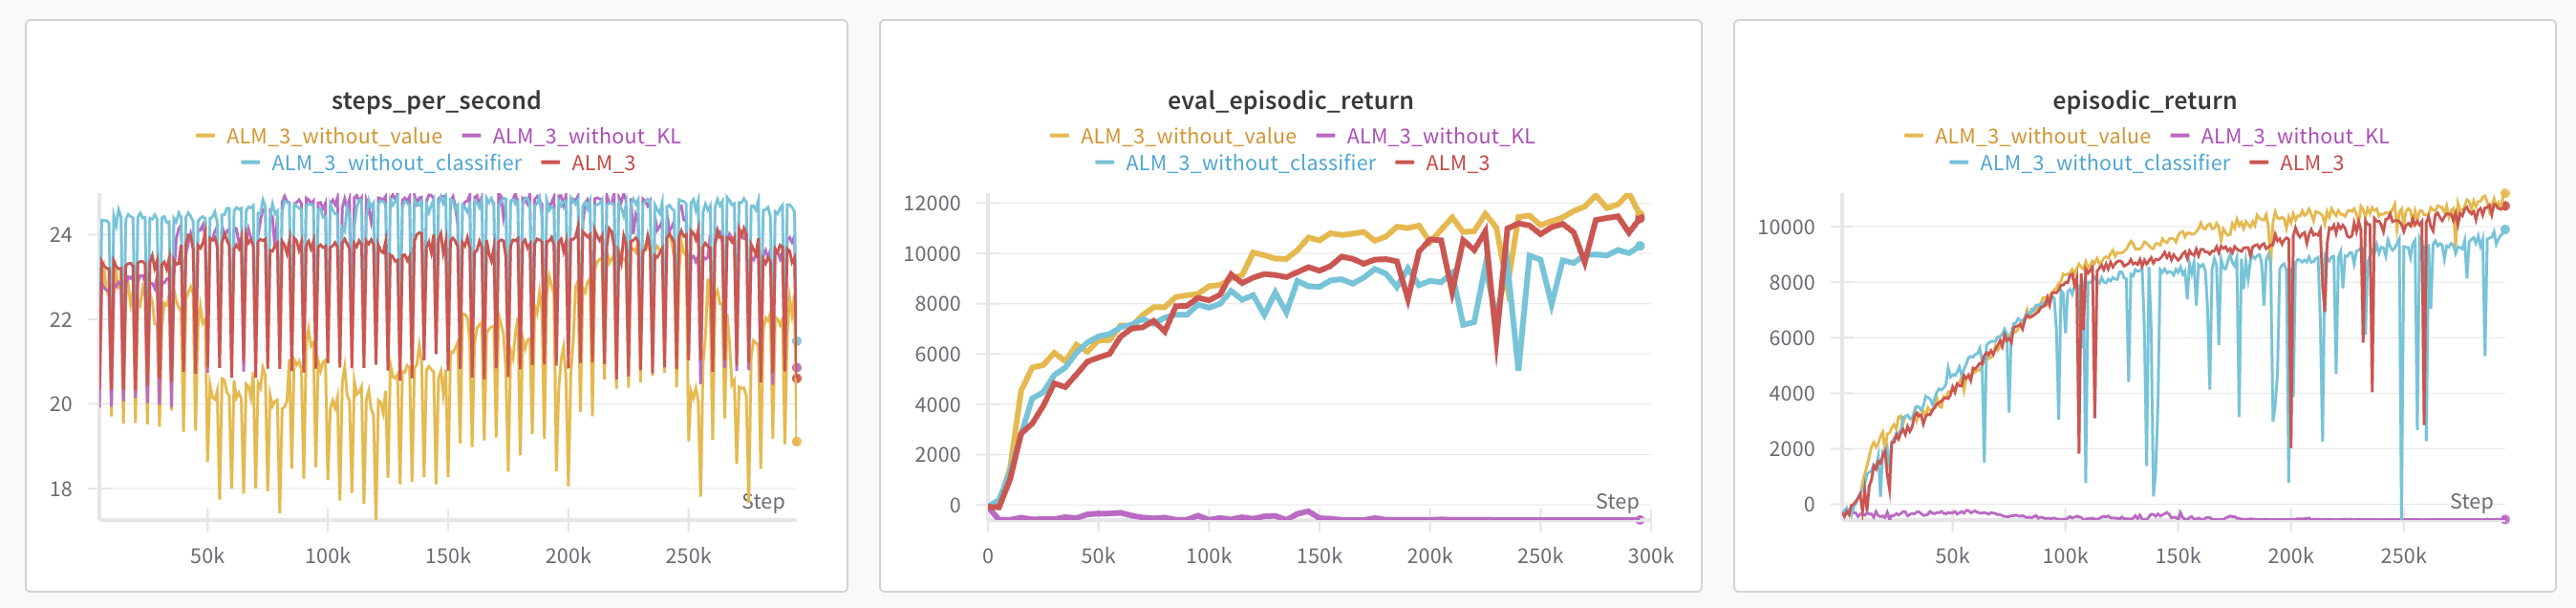


Наконец последний эксперимент это сравнение модели с encoder и без нее. Для этого мне потребовалось добавить свое дельта распределение в код. Этим экспериментом авторы показывают, что обучение своего encoder'а под каждую среду дает больше преимущество.

[Результаты](https://wandb.ai/polinasha-team/alm_HalfCheetah-v2/runs/6gvsvzt8?nw=nwuserpolinasha960)

In [ ]:
!python3 ./alm/train.py id=HalfCheetah-v2 wandb_log=True save_snapshot=True num_train_steps=300000 seq_len=3 wandb_run_name='ALM_3_with_fully_identiy_encoder' seed=239 use_identity_encoder=True

Хотя авторы и не запускали эксперимент на среде гепарда, наши результаты сошлись

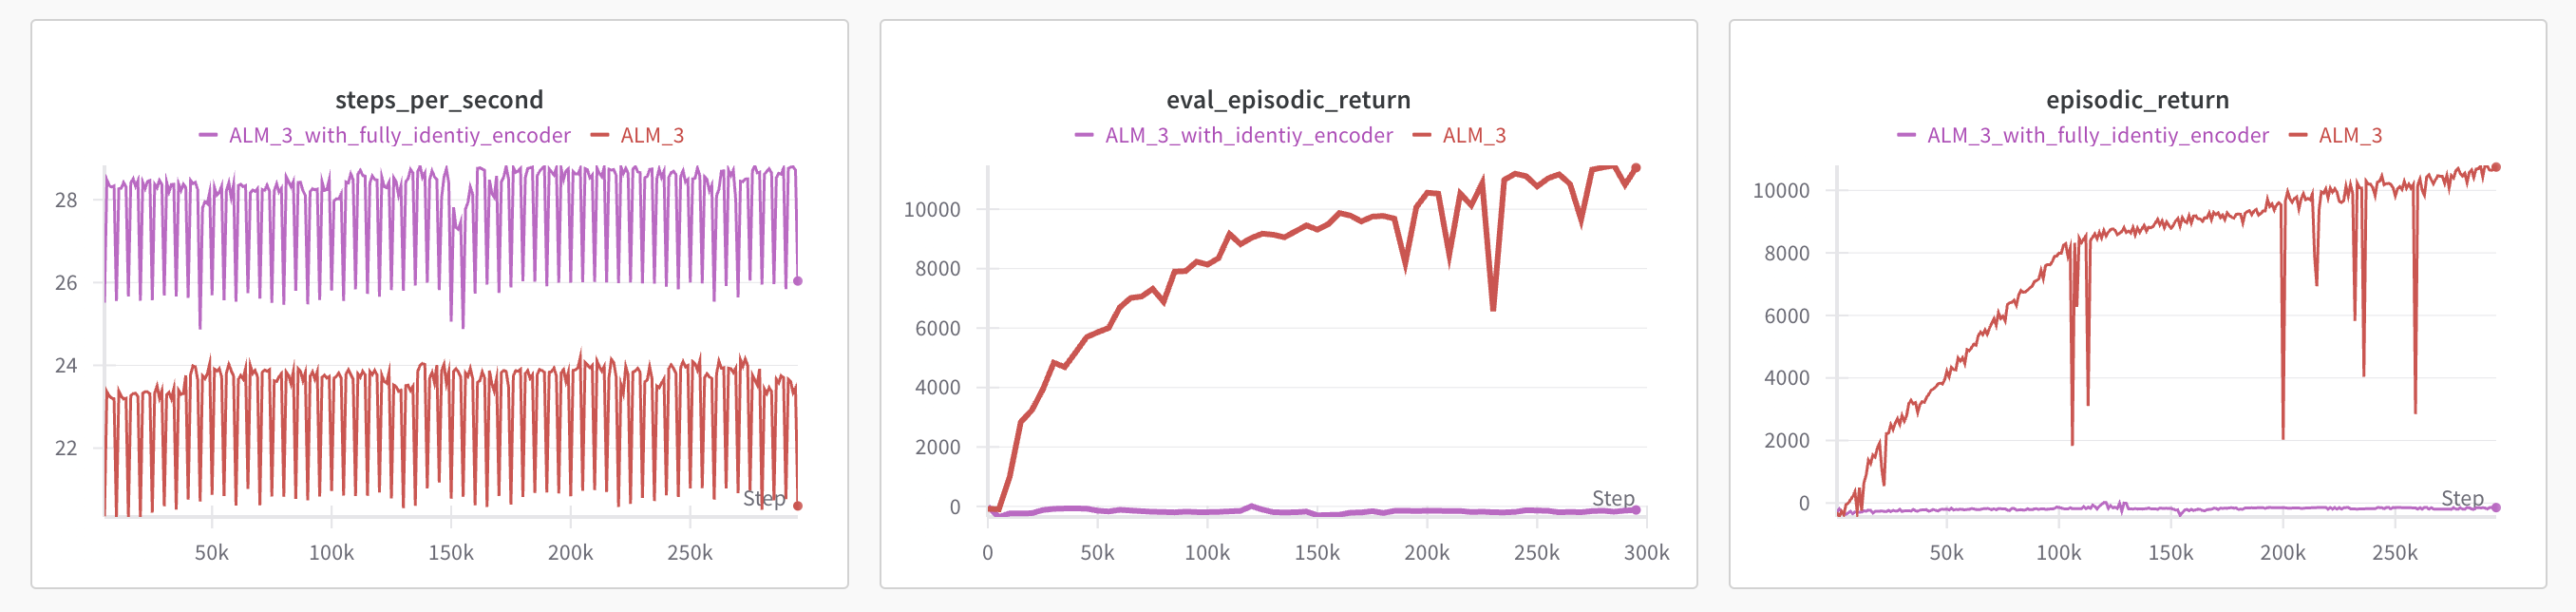

В целом могу сказать, что алгоритм достаточно быстро учится, по сравнению с моделями-ансамблями. По сравнению с другими алгоритмами, репозиторий с кодом был хорош (по крайней мере там было все понятно и не было странного способа логироания выводом в консоль).

У меня сложилось ощущщение, что ревард в данном случае зависит сильно от сида. У меня есть отличия примерно в 1000 реварда от авторов (причем в обе стороны), что наверно не есть хороошо, потому что это примерно шестая часть от общего выйгрыша.

Улучшиение после убирания Value части лосса на мой взгляд связано с переобучением или с более простой функцией лосса, что ведет к более быстрому обучению. Или это все же везение. Мне кажется здесь, можно провести какие-то отдельные исследования.

Однако расстраивает, что во всех репозиториях абсолютно нерабочие версии библиотек, то есть репозитории уже пару лет не обновлялись и пришлось потратить много усилий, чтобы все запустить.

# Другие модели


Хочется отметить, что хоть это и не нужно было, я сделала запуск других моделей для честного сравнения качества и времени работы.

Все запуски можно посмотреть [здесь](https://wandb.ai/polinasha-team/alm_HalfCheetah-v2)

## RED-Q

Здесь я тоже меняла код, чтобы добавить логгирование в wandb

In [ ]:
!pip install -r ./redq/requirements.txt
%cd redq
!pip install -e .
!mkdir ./checkpoints
!python3 ./experiments/train_redq_sac.py --seed 239 --env 'HalfCheetah-v2' --exp_name 'redq'

## MBPO

Так как MBPO работает очень долго, я замерила только время его одного шага, а результаты обучения взяла в их официальном репозитории. Добавила в репозиторий код настройки. Код самого запуска:

In [ ]:
!python ./mbpo_pytorch/mbpo_pytorch/scripts/run_mbpo.py --set seed=0 verbose=1 device="cuda:0" env.env_name='HalfCheetah'

## SAC и TD3

Добавила также блокнот с нстройкой в репозиторий. Сами запуски:

In [ ]:
!cd cleanrl && poetry run python3.10 cleanrl/td3_continuous_action.py \
    --seed 1 \
    --policy-frequency 1 \
    --env-id HalfCheetah-v4 \
    --total-timesteps 300000 \
    --track \
    --wandb-project-name alm_HalfCheetah-v2

In [ ]:
!cd cleanrl && poetry run python3.10 cleanrl/sac_continuous_action.py \
    --seed 1 \
    --policy-frequency 1 \
    --env-id HalfCheetah-v4 \
    --total-timesteps 300000 \
    --track \
    --wandb-project-name alm_HalfCheetah-v2